In [2]:
import pickle
import bson
import pandas as pd
import pandas as pd
import numpy as np
import shap
import os
import recursive_feature_elimination
import pickle
from bson.objectid import ObjectId
from collections import defaultdict
import timeit
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns


pd.set_option('display.max_columns', None)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
os.chdir("/Users/sakshamarora/Documents/6748 Practicum/project/GT_MSA_LBA")

In [4]:
league = "NCAAW1+"
season = "22-23"

In [5]:
merged_df_with_3P = pd.read_pickle(f'data/processed_data/{league}_{season}_3P.pickle')


In [6]:
def clean_column_names(df):
    df.columns = df.columns.str.replace('[{}:,"]', '', regex=True)  # Replace special JSON characters
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    return df

X = merged_df_with_3P.drop([
    'game_id', 'team_id', 'team_id', 'season_id', 'player_id', 'shot_id', 'segment_id', 'date', 
    'has_locations', 'has_segments', 'team1', 'team2', 'hometeam', 'Made', 'Time', 'Stat', 'season', 
    'league', 'score','winning_team','Fastbreak',
    'score_opp', 'And1', 'Blocked', 'Assisted'
], axis=1)

X = clean_column_names(X)

categorical_features = ['Location', 'Zone','Period','LBA_position', 'year', 'Shot_type'] 

# Convert the columns to 'category' type
for col in categorical_features:
    if col in X.columns:  # Check if the column exists in the DataFrame
        X[col] = X[col].astype('category')

# Use 'Made' as the target variable
y = merged_df_with_3P['Made']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Info] Number of positive: 53917, number of negative: 119642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12554
[LightGBM] [Info] Number of data points in the train set: 173559, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310655 -> initscore=-0.797058
[LightGBM] [Info] Start training from score -0.797058


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")

Train-------------------------------
Train Accuracy: 0.35343024562252606
Train Precision: 0.3217628967465408
Train Recall: 0.9760186954021922
Train F1 Score: 0.4839745063596148
Train AUC ROC: 0.615065785559546
Test-------------------------------
Test Accuracy: 0.34763770454021664
Test Precision: 0.3196735332209271
Test Recall: 0.965675057208238
Test F1 Score: 0.4803378006241968
Test AUC ROC: 0.5606193920225524
Optimum Threshold for Maximum F1 Score: 0.24


Text(0.5, 1.0, 'Feature Importance')

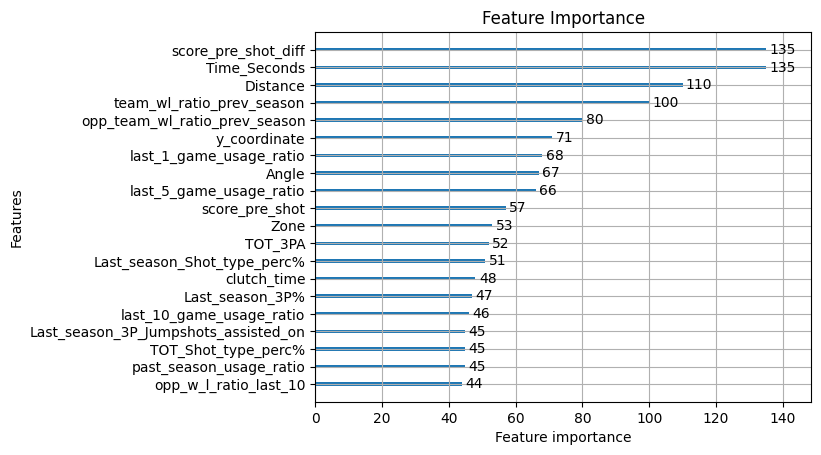

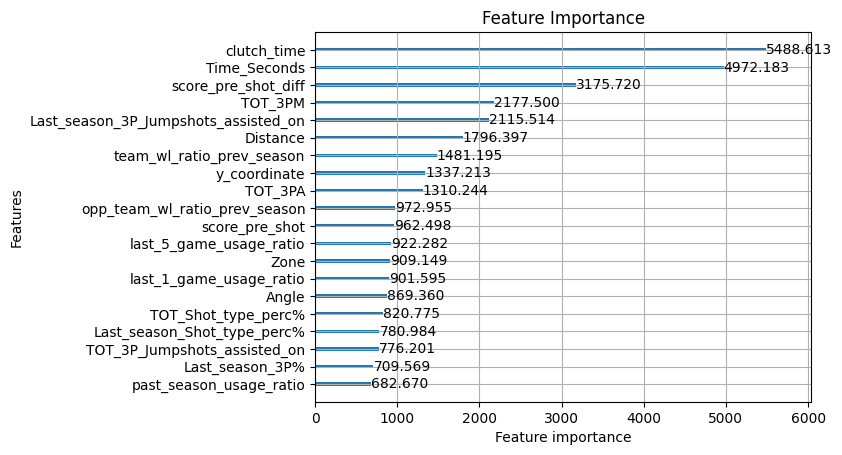

In [10]:
lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

In [11]:
y_train_pred_3p = y_train_pred
best_threshold_3p = best_threshold
y_pred_3p = y_pred
y_train_3p = y_train
y_test_3p = y_test
X_3p = X

In [12]:
# Function to plot probabilities
def plot_probabilities(probs, title):
    sns.histplot(probs, kde=True, bins=30)
    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def calculate_combined_probabilities(prob_2p, prob_3p):
    weighted_2p = prob_2p * 2
    weighted_3p = prob_3p * 3
    return np.concatenate([weighted_2p, weighted_3p])

In [13]:
# Displaying the best thresholds
# print(f"Best threshold for 2-pointers: {best_threshold_2p}")
print(f"Best threshold for 3-pointers: {best_threshold_3p}")

# Apply the best threshold to get binary predictions
# y_train_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_train_pred_2p]
y_train_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_train_pred_3p]
# y_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_pred_2p]
y_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_pred_3p]

Best threshold for 3-pointers: 0.24


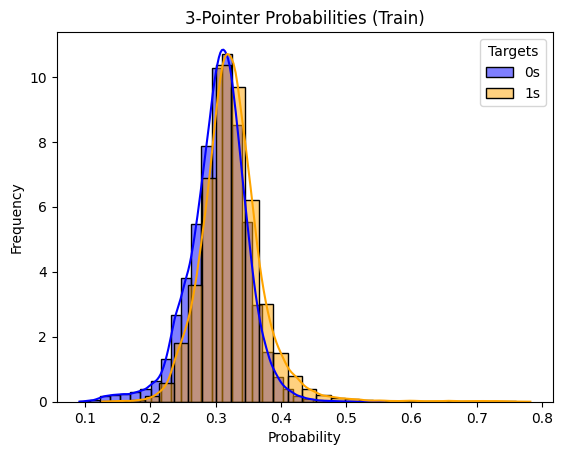

In [14]:
def plot_probabilities_class(probs_0, probs_1, title):
    sns.histplot(probs_0, kde=True, color='blue', bins=30, label='0s', stat='density')
    sns.histplot(probs_1, kde=True, color='orange', bins=30, label='1s', stat='density')

    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(title='Targets')
    plt.show()

# y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
# y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

# plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')
plot_probabilities_class(y_train_pred_0_3p, y_train_pred_1_3p, '3-Pointer Probabilities (Train)')

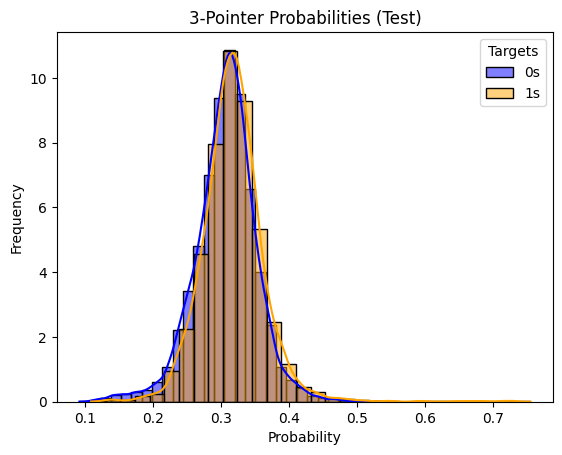

In [15]:
# y_test_pred_2p = np.array(y_pred_2p)
y_test_pred_3p = np.array(y_pred_3p)
# y_test_2p = np.array(y_test_2p)
y_test_3p = np.array(y_test_3p)

# y_test_2p = y_test_2p.reshape(-1)
y_test_3p = y_test_3p.reshape(-1)

# y_test_pred_0_2p = y_test_pred_2p[y_test_2p == 0]
# y_test_pred_1_2p = y_test_pred_2p[y_test_2p == 1]
y_test_pred_0_3p = y_test_pred_3p[y_test_3p == 0]
y_test_pred_1_3p = y_test_pred_3p[y_test_3p == 1]

# plot_probabilities_class(y_test_pred_0_2p, y_test_pred_1_2p, '2-Pointer Probabilities (Test)')
plot_probabilities_class(y_test_pred_0_3p, y_test_pred_1_3p, '3-Pointer Probabilities (Test)')

# Feature Reduction

In [16]:
rfe_object = recursive_feature_elimination.rfe(X_train,y_train,X_test,y_test,categorical_features)

[LightGBM] [Info] Number of positive: 53917, number of negative: 119642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12554
[LightGBM] [Info] Number of data points in the train set: 173559, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310655 -> initscore=-0.797058
[LightGBM] [Info] Start training from score -0.797058
[LightGBM] [Info] Number of positive: 53917, number of negative: 119642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12502
[LightGBM] [Info] Number of data points in the train set: 173559, number of used features: 108
[LightGBM]

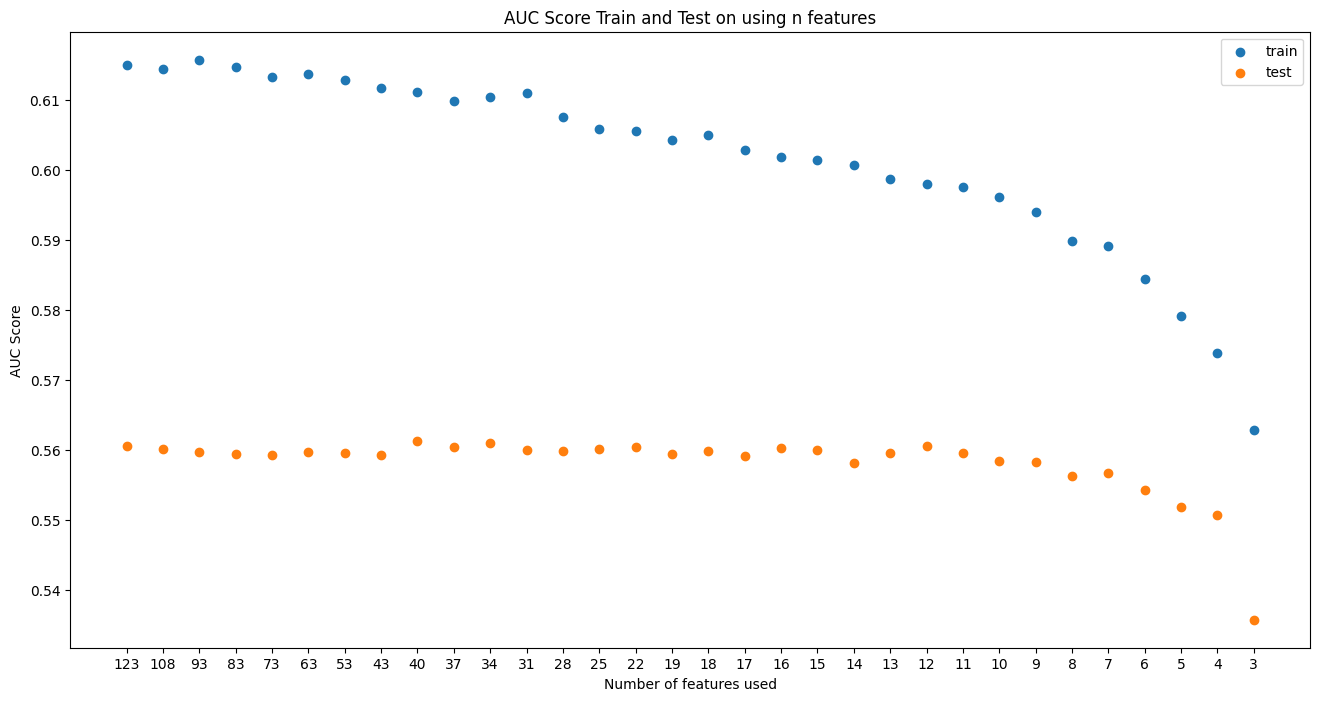

In [17]:
df,fig = rfe_object.run_rfe()

In [18]:
SELECT_TOP_K_FEATURES = 25
rfe_object.get_top_k_feature_list(SELECT_TOP_K_FEATURES)

array(['clutch_time', 'Time_Seconds', 'score_pre_shot_diff', 'TOT_3PM',
       'Last_season_3P_Jumpshots_assisted_on', 'Distance',
       'team_wl_ratio_prev_season', 'opp_team_wl_ratio_prev_season',
       'TOT_3PA', 'Last_season_3PM', 'score_pre_shot', 'y_coordinate',
       'last_1_game_usage_ratio', 'Angle', 'TOT_Shot_type_attempted',
       'past_season_usage_ratio', 'L5_Shot_type_perc%',
       'last_5_game_usage_ratio', 'Last_season_Shot_type_perc%',
       'TOT_Shot_type_perc%', 'L5_3PA', 'TOT_3P_Jumpshots_assisted_on',
       'L10_Shot_type_perc%', 'Last_season_3P%', 'TOT_3P%'], dtype=object)

### Reduced features

In [19]:
Three_features_reduced = ['clutch_time', 'Time_Seconds', 'score_pre_shot_diff', 'TOT_3PM',
       'Last_season_3P_Jumpshots_assisted_on', 'Distance',
       'score_pre_shot', 'TOT_Shot_type_perc%',
       'team_wl_ratio_prev_season', 'TOT_3PA',
       'opp_team_wl_ratio_prev_season', 'Last_season_3PM',
       'L5_Shot_type_perc%', 'last_1_game_usage_ratio',
       'last_3_game_usage_ratio', 'y_coordinate',
       'Last_season_Shot_type_perc%', 'TOT_Shot_type_attempted',
       'current_season_usage_ratio', 'Angle', 'past_season_usage_ratio',
       'TOT_Zone_perc%', 'L5_3PA', 'TOT_3P_Jumpshots_assisted_on',
       'Last_season_Zone_attempted']

In [20]:
print(X[Three_features_reduced].dtypes)

clutch_time                               int64
Time_Seconds                              int64
score_pre_shot_diff                       int64
TOT_3PM                                 float64
Last_season_3P_Jumpshots_assisted_on    float64
Distance                                float64
score_pre_shot                            int64
TOT_Shot_type_perc%                     float64
team_wl_ratio_prev_season               float64
TOT_3PA                                 float64
opp_team_wl_ratio_prev_season           float64
Last_season_3PM                         float64
L5_Shot_type_perc%                      float64
last_1_game_usage_ratio                 float64
last_3_game_usage_ratio                 float64
y_coordinate                            float64
Last_season_Shot_type_perc%             float64
TOT_Shot_type_attempted                 float64
current_season_usage_ratio              float64
Angle                                   float64
past_season_usage_ratio                 

In [21]:
X_subset = X[Three_features_reduced]

Correlation check

In [22]:
numeric_cols = X_subset.select_dtypes(include=['bool', 'float64', 'int64']).columns
X_subset_numeric = X_subset[numeric_cols]

def remove_highly_correlated_features(df, threshold):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    while True:
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        if not to_drop:
            break

        feature_to_drop = to_drop[0]
        df = df.drop(columns=[feature_to_drop])
        print(f"Dropping feature: {feature_to_drop}")

        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    return df

threshold = 0.7
X_reduced = remove_highly_correlated_features(X_subset_numeric, threshold)


Dropping feature: TOT_3PA
Dropping feature: Last_season_3PM
Dropping feature: last_3_game_usage_ratio
Dropping feature: TOT_Shot_type_attempted
Dropping feature: L5_3PA


In [23]:
categorical_cols = X_subset.select_dtypes(include=['category']).columns
print(categorical_cols)
X_final = pd.concat([X_reduced, X_subset[categorical_cols]], axis=1)

Index([], dtype='object')


In [24]:
print(X_subset.shape)
print(X_final.shape)

(216949, 25)
(216949, 20)


Final model

In [25]:
categorical_features = [] 

# Convert categorical columns to 'category' type
for col in categorical_features:
    if col in X_final.columns:  # Check if the column exists in the DataFrame
        X_final[col] = X_final[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [26]:
# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Info] Number of positive: 53917, number of negative: 119642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 173559, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.310655 -> initscore=-0.797058
[LightGBM] [Info] Start training from score -0.797058


In [27]:
def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")

Train-------------------------------
Train Accuracy: 0.3650055600689103
Train Precision: 0.32403911075545777
Train Recall: 0.9613294508225606
Train F1 Score: 0.4846988633441342
Train AUC ROC: 0.605723635611454
Test-------------------------------
Test Accuracy: 0.3581470384881309
Test Precision: 0.3211633199129761
Test Recall: 0.948032774784085
Test F1 Score: 0.47978930065750147
Test AUC ROC: 0.558377986302327
Optimum Threshold for Maximum F1 Score: 0.25


Text(0.5, 1.0, 'Feature Importance')

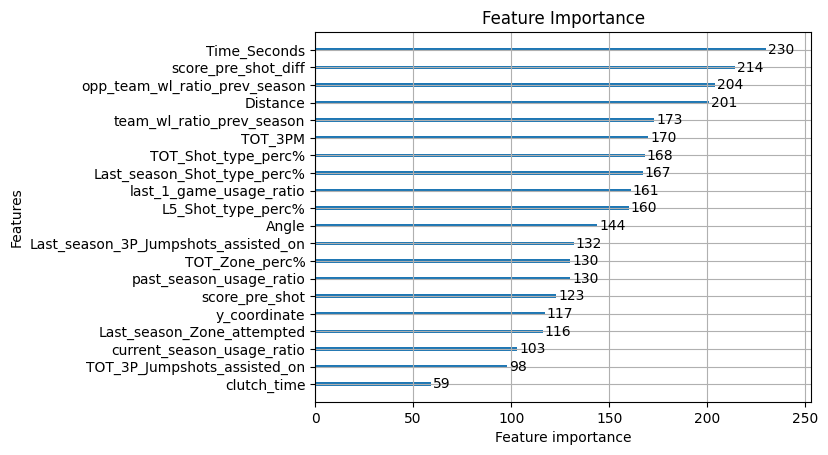

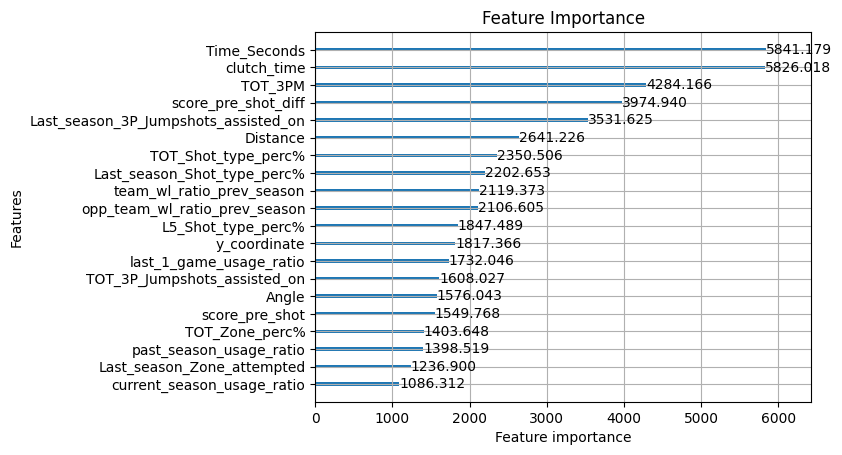

In [28]:
lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

In [29]:
y_train_pred_3p = y_train_pred
best_threshold_3p = best_threshold
y_pred_3p = y_pred
y_train_3p = y_train
y_test_3p = y_test
X_3p = X

In [30]:
# Displaying the best thresholds
# print(f"Best threshold for 2-pointers: {best_threshold_2p}")
print(f"Best threshold for 3-pointers: {best_threshold_3p}")

# Apply the best threshold to get binary predictions
# y_train_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_train_pred_2p]
y_train_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_train_pred_3p]
# y_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_pred_2p]
y_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_pred_3p]

Best threshold for 3-pointers: 0.25


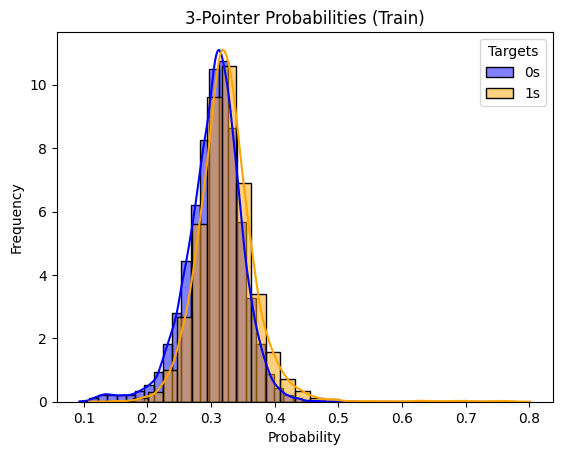

In [31]:
def plot_probabilities_class(probs_0, probs_1, title):
    sns.histplot(probs_0, kde=True, color='blue', bins=30, label='0s', stat='density')
    sns.histplot(probs_1, kde=True, color='orange', bins=30, label='1s', stat='density')

    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(title='Targets')
    plt.show()

# y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
# y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

# plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')
plot_probabilities_class(y_train_pred_0_3p, y_train_pred_1_3p, '3-Pointer Probabilities (Train)')

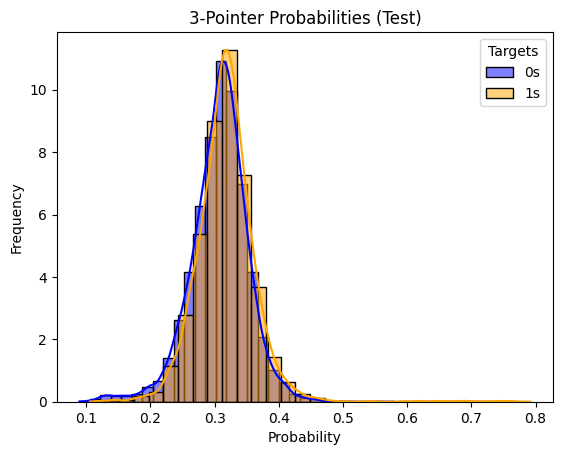

In [32]:
# y_test_pred_2p = np.array(y_pred_2p)
y_test_pred_3p = np.array(y_pred_3p)
# y_test_2p = np.array(y_test_2p)
y_test_3p = np.array(y_test_3p)

# y_test_2p = y_test_2p.reshape(-1)
y_test_3p = y_test_3p.reshape(-1)

# y_test_pred_0_2p = y_test_pred_2p[y_test_2p == 0]
# y_test_pred_1_2p = y_test_pred_2p[y_test_2p == 1]
y_test_pred_0_3p = y_test_pred_3p[y_test_3p == 0]
y_test_pred_1_3p = y_test_pred_3p[y_test_3p == 1]

# plot_probabilities_class(y_test_pred_0_2p, y_test_pred_1_2p, '2-Pointer Probabilities (Test)')
plot_probabilities_class(y_test_pred_0_3p, y_test_pred_1_3p, '3-Pointer Probabilities (Test)')

## SHAP for Explainability and Sanity Check

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


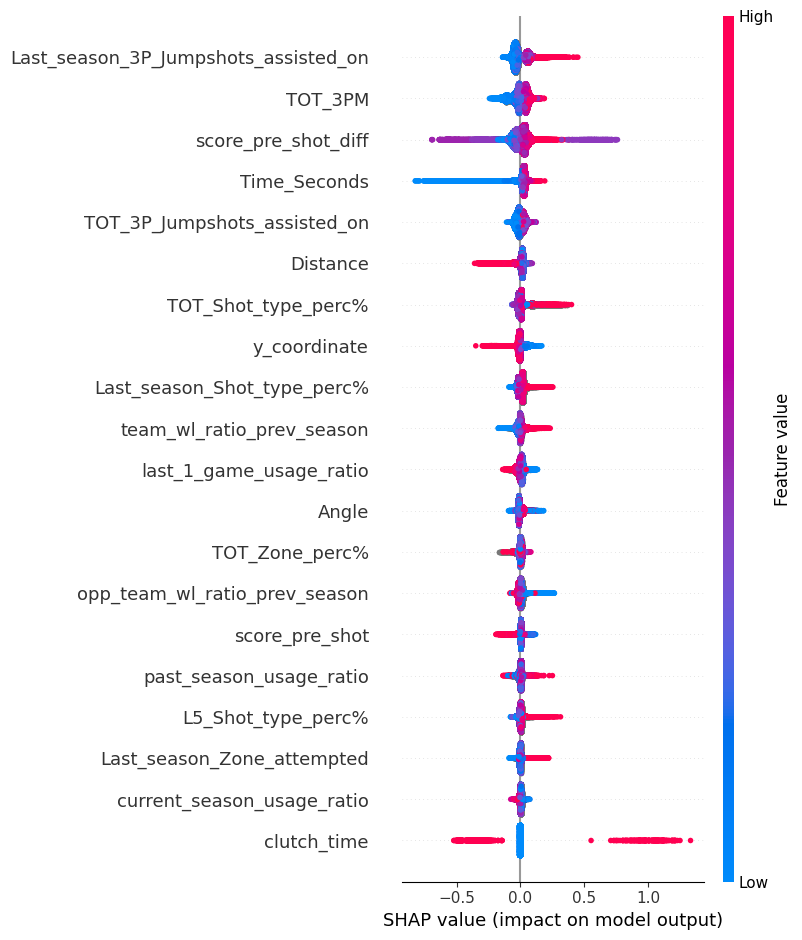

In [33]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train, plot_type='dot')

In [34]:
bst.save_model(f'Inference/3p_{league}_{season}_model.txt')